In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import tensorflow as tf
import keras.layers as layers
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
import string
import numpy as np
import pandas as pd

2022-12-15 14:14:05.467316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# experiment name
name = 'both_generated_using_correct_names_20k'

# Dataset

In [8]:
df = pd.read_csv(f"data/{name}.csv")
print(df.shape)
df.sample(10)

FileNotFoundError: [Errno 2] No such file or directory: 'data/lstm_both_generated_using_correct_names_20k.csv'

In [9]:
# max number of words per name
df['Name'].str.split().str.len().max()

3

In [10]:
df.head(5)

,Name,class
0,حمايه تيسير لاوند,1.0
1,سعداحمد ابراهبم برى,1.0
2,مكة ولاء كريمه,1.0
3,زايد ثراء سحاق,1.0
4,الاسمر الشندى العوضى,1.0


In [11]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Name,class
0,يستحقون ملائكة اعترض,0.0
1,جىئرا ازنور هسابنىل,0.0
2,قسم السماء روينه,1.0
3,مجهولة بمظهر قلمك,0.0
4,جنى طلعت ياسرابراهيم,1.0


## Document Preprocessing

In [12]:
# adding start and end tokens
names = ['<SOS> ' + x + ' <EOS>' for x in df['Name'].tolist()]
corpus = " ".join(names)
labels = df['class'].tolist()
corpus[:1000]

'<SOS> يستحقون ملائكة اعترض <EOS> <SOS> جىئرا ازنور هسابنىل <EOS> <SOS> قسم السماء روينه <EOS> <SOS> مجهولة بمظهر قلمك <EOS> <SOS> جنى طلعت ياسرابراهيم <EOS> <SOS> داود اطوار شوكت <EOS> <SOS> مالاسيلعد بسيعابحلدب لارمن <EOS> <SOS> الدسوقى مجدولين روثاء <EOS> <SOS> رراغدااء فارس فريينا <EOS> <SOS> البتول هنيات شنودة <EOS> <SOS> الددامونى الصافى نشات <EOS> <SOS> الدساوى شيماء عبداللـه <EOS> <SOS> نىازت المعداوى طالع <EOS> <SOS> عاببدد ابوعلى غندر <EOS> <SOS> عزوز سحاب بيلاجيا <EOS> <SOS> فيلمه النصب فجاة <EOS> <SOS> النخاع ملكا الدرس <EOS> <SOS> عقل عزالدين باشه <EOS> <SOS> نيجار زمزم المرسى <EOS> <SOS> ذاكرته الرؤى للمشاهد <EOS> <SOS> منصورعبدالغنى مانويل صديقه <EOS> <SOS> عطايه قدريه عطيات <EOS> <SOS> يعتقدون أخطأت أصبحوا <EOS> <SOS> نفاده هلالى -االشررببينى <EOS> <SOS> كعادتها لسرد التشك <EOS> <SOS> انهيته لغادة ععبدالننظوور <EOS> <SOS> روجين حمدينو الفاتح <EOS> <SOS> الجزايرى القاوقجى ىولرحا <EOS> <SOS> همس طمان كرومل <EOS> <SOS> شابى ريتال ابوعرب <EOS> <SOS> الذكى ماررسلينو الددرينى

## Tokenization 

In [13]:
tokenize = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', lower=False)
tokenize.fit_on_texts(names)
x = tokenize.texts_to_sequences(names)
max_len = 6
x = tf.keras.utils.pad_sequences(x, maxlen=max_len, padding='post')
total_words = len(tokenize.word_index)+1
print(f"Total Words: {total_words}")
print("Example of a Sequence")
print(x[:3])
print("Some Tokens")
print(list(tokenize.word_index)[:10])

Total Words: 13574
Example of a Sequence
[[    2 10761  7768  4340     3     0]
 [    2  7769 10762  7770     3     0]
 [    2  1025   317  1026     3     0]]
Some Tokens
['<UNK>', '<SOS>', '<EOS>', 'عطوان', 'اعتماد', 'ثريا', 'التزام', 'حكمه', 'جمال', 'هنداوى']


## Splitting data and making dataset 

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(x, df['class'].values, test_size=.2, random_state=23)
print("Train and Validation sizes")
len(x_train), len(x_valid), len(y_train), len(y_valid)

Train and Validation sizes


(16000, 4000, 16000, 4000)

In [15]:
# number of possitive examples, should be near half its split 
y_train.sum(), y_valid.sum()

(8038.0, 1962.0)

In [16]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(128)

2022-12-15 14:04:43.507981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 14:04:43.555709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 14:04:43.555914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 14:04:43.556529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [17]:
for x,y in ds_train.take(1):
    print(x[:2], y[:2])

tf.Tensor(
[[   2  966 3172  370    3    0]
 [   2  120 1014 1658    3    0]], shape=(2, 6), dtype=int32) tf.Tensor([1. 1.], shape=(2,), dtype=float64)


# Build and Train a Model: 

In [23]:
vocab_size = total_words
embedding_dim = 64
sequence_length = max_len
rnn_units = 64

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units)),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          868736    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 943,105
Trainable params: 943,105
Non-trainable params: 0
________________________________________________

In [25]:
model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy())

In [26]:
epochs = 10
early_stopping = EarlyStopping(patience=4, restore_best_weights=True, verbose=True)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/10
125/125 [==============================] - 3s 10ms/step - loss: 0.4722 - binary_accuracy: 0.6956 - val_loss: 0.1800 - val_binary_accuracy: 0.9293
Epoch 2/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0803 - binary_accuracy: 0.9698 - val_loss: 0.2075 - val_binary_accuracy: 0.9377
Epoch 3/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_accuracy: 0.9918 - val_loss: 0.3052 - val_binary_accuracy: 0.9305
Epoch 4/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0161 - binary_accuracy: 0.9952 - val_loss: 0.2955 - val_binary_accuracy: 0.9342
Epoch 5/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0145 - binary_accuracy: 0.9956 - val_loss: 0.3708 - val_binary_accuracy: 0.9290
Epoch 5: early stopping


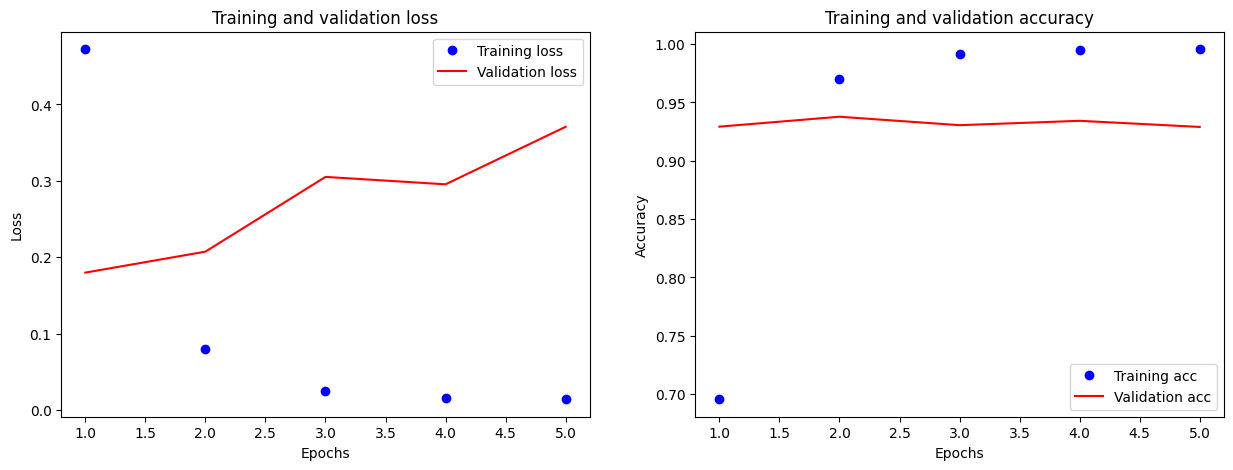

In [27]:
from utils import plot_history
plot_history(history.history)

### Test Examples 

In [28]:
#new
example = '<sos> ' + "معاذ طه عوض" + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 464ms/step


array([[0.8805222]], dtype=float32)

In [29]:
#new
example = "باسم وحيد السيد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 35ms/step


array([[0.8083002]], dtype=float32)

In [30]:
#new
example = "شسي شسي شسي"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.02876634]], dtype=float32)

In [31]:
#new
example = "باسمم وحةد السد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 37ms/step


array([[0.02876634]], dtype=float32)

In [32]:
#new
example = "مريم محمد محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 37ms/step


array([[0.80538213]], dtype=float32)

In [33]:
#new
example = "محمد مريم محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 32ms/step


array([[0.8162992]], dtype=float32)

In [34]:
#new
example = "مريم محمد الرمال"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 37ms/step


array([[0.106912]], dtype=float32)

In [35]:
#new
example = "محمد طه عوض"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 36ms/step


array([[0.8518837]], dtype=float32)

In [37]:
#new
example = "زيادد عبدالرحمنت محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 42ms/step


array([[0.1401768]], dtype=float32)

In [45]:
#new
example = "دزيادد محمد سشيبسيب "
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 60ms/step


array([[0.13343678]], dtype=float32)

In [46]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 32ms/step


array([[0.9253821]], dtype=float32)

# Saving and loading the trained model 

In [59]:
model.save(f'models/{name}_lstm_model.h5')

In [60]:
new_model = tf.keras.models.load_model(f'models/{name}_lstm_model.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          868736    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 943,105
Trainable params: 943,105
Non-trainable params: 0
________________________________________________

## Saving and loading the tokenizer

In [61]:
import pickle

# saving
with open(f'models/{name}tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open(f'models/{name}tokenizer.pickle', 'rb') as handle:
    new_tokenizer = pickle.load(handle)

In [62]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 448ms/step


array([[0.9253821]], dtype=float32)

In [63]:
#new
example = "زيادد عبدالرحمنت محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 479ms/step


array([[0.1401768]], dtype=float32)